# Example notebook for working with AU-SAR Gridded DM Winds from the AODN Thredds server     

This notebook demonstrates: 
* basic reading and visualising the SAR Wind Gridded product
* working with multiple SAR wind data and visualising full spatial coverage
* selecting a region of interest

Below is a list of required Python packages:
- Python 3.12.3
- Cartopy==0.23.0
- matplotlib==3.8.4
- numpy==1.26.4
- siphon==0.9
- xarray==2024.3.0

Date: 13.November.2025         
Prepared by:      
Marites Canto (tess.canto@csiro.au); Salman Khan (salmansaeed.khan@csiro.au)     
Please send query to tess.canto@csiro.au     
Relevant publication: https://doi.org/10.1038/s41597-023-02046-w

## Load python packages

In [1]:
import os, glob
import sys    
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path

import cartopy as cart
import cartopy.feature as cfeature
from siphon.catalog import TDSCatalog

In [2]:
from datetime import date, timedelta
from os.path import exists
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.colors as mcolors

In [3]:
import requests
import xml.etree.ElementTree as ET

In [4]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from PIL import Image

In [5]:
import dask
import logging
from dask.distributed import Client

In [ ]:
client = Client(threads_per_worker=1,memory_limit=0,silence_logs=logging.ERROR)
client

In [7]:
##---Shutdown dask connection
# client.close()  

In [8]:
#---Helper functions for plotting wind direction
def met2math(wdir_met):
    '''
    meteorological wdir is the from direction rel. to North
    '''
    return (270. - wdir_met)  % 360.

def to_uv(ws, phi):
    '''
    Here phi needs to be the math angle of wind
    relative to east and positive anti-clockwise
    can be 0-360 or +-180, I think it doesn't matter
    as the function internally handles it
    e.g. to_uv(10, -45) == to_uv(10, 360-45)
    or.  to_uv(10, -90) == to_uv(10, 270)
    '''
    u = ws * np.cos(np.deg2rad(phi))
    v = ws * np.sin(np.deg2rad(phi))
    return u, v

#---Helper function for plotting
def savefig(fig, filename, dpi = 300):
    """Save a fig with 0 padding.
       Args:
           - fig (matplotlib.figure.Figure): a figure object
           - filename (str): path and filename to save
    """
    try:
        fig.savefig(filename, bbox_inches = 'tight', pad_inches = 0.1, dpi = dpi)
    except:
        sys.exit('Figure: {0:s} could not be saved.'.format(filename))
pass


In [9]:
#---Define an array for colour and contour levels
contour_clrs = np.array(([212, 212, 212],
                      [170,170,170],
                      [129,129,129],
                      [88,88,88],
                      [181,209,228],
                      [127,165,199],
                      [73,121,170],
                      [20, 77, 141],
                      [177, 220, 173],
                      [126,179,130],
                      [75,138,87],
                      [25,97, 45],
                      [254, 253, 174],
                      [245,186,129],
                      [237,119,84],
                      [229, 52, 39],
                      [246, 10, 29],
                      [190, 57, 194]))/255.0
levels = np.array((0, 1, 2, 3, 4, 5, 6.5, 8, 9.5, 11, 12.5, 14, 15.5, 17.5, 19.5, 21.5, 25, 30))

#---Create a custom colour map using the colours and levels
cmap = mcolors.ListedColormap(contour_clrs)

#---Set the colour of land pixels
land_clr = (247/255, 206/255, 160/255)

## Opening and visualising a single SAR file         

Basic notebook to load and visualise a SAR wind file directly from THREDDS
</br>
THREDDS: https://thredds.aodn.org.au/thredds/catalog/IMOS/SRS/Surface-Waves/SAR_Wind/DELAYED/GRIDDED/SENTINEL-1/catalog.html

In [10]:
opendap_links = 'https://thredds.aodn.org.au/thredds/dodsC/IMOS/SRS/Surface-Waves/SAR_Wind/DELAYED/GRIDDED/SENTINEL-1/2023/03/IMOS_SRS-Surface-Waves_M_20230321_Gridded-Coastal-Wind-Sentinel-1_FV02.nc'
dset = xr.open_dataset(opendap_links)

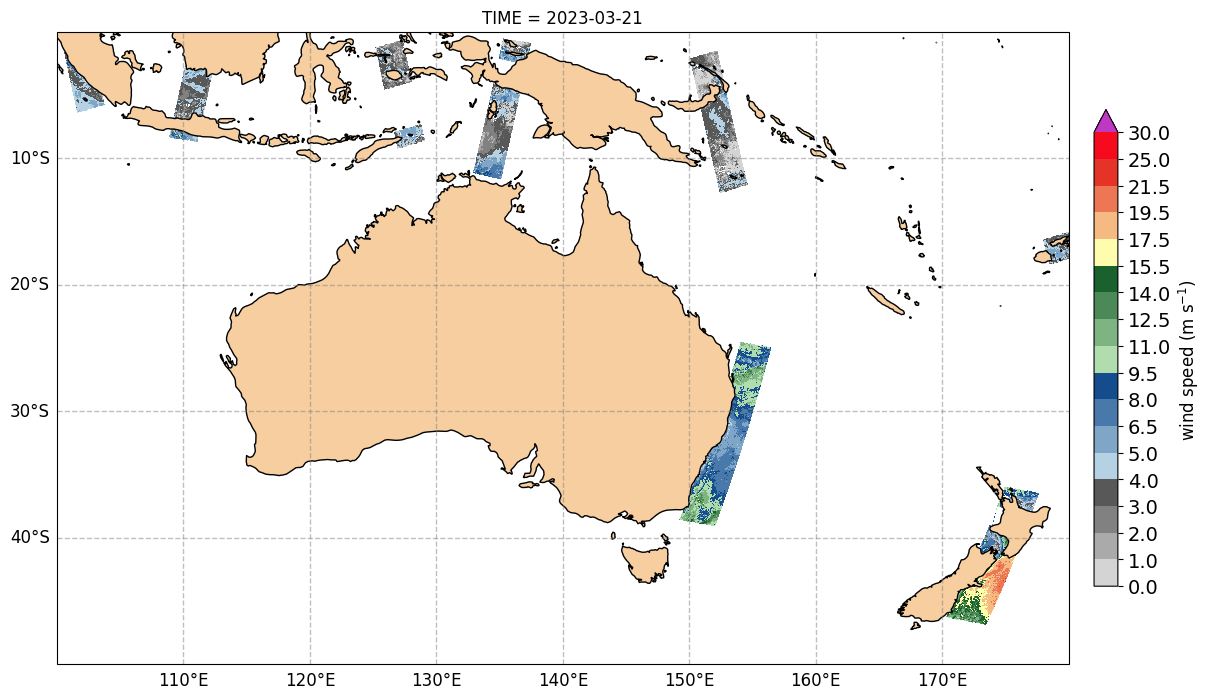

In [11]:
#---Define map extent for plotting
extent = (-80, 0, 0, -50)

#---Create the figure
fig = plt.figure(figsize=(12,12), dpi=100, layout='constrained')
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m'), edgecolor='k', facecolor=land_clr, linewidth=1)

# Add grid lines
gl = ax.gridlines(crs = ccrs.PlateCarree(), 
                  draw_labels = True, 
                  linewidth = 1, 
                  color = 'gray', 
                  alpha = 0.5, 
                  linestyle = '--')

# Set axis labels and style
gl.xlabel_style = {'fontsize': 12}
gl.ylabel_style = {'fontsize': 12}
gl.top_labels = None
gl.right_labels = None

# Set uniform map extent 
ax.set_extent(extent, cart.crs.PlateCarree(central_longitude = 180))

# Add data contour: CALIBRATED WIND SPEED
cs = dset.WSPD_CAL.plot(ax=ax, 
                        cmap=cmap,
                        levels=levels,
                        add_colorbar=False,)

# Add colour bar
cbar = fig.colorbar(cs, ax=ax, boundaries=levels,
                    orientation = 'vertical', 
                    label = 'wind speed (m s-1)', 
                    aspect = 20,
                    shrink = 0.4, 
                    pad = 0.025)
cb_label = r"wind speed (m s$^{-1}$)"
cbar.ax.tick_params(labelsize = 14)
cbar.set_label(label = cb_label, size = 12)
cbar.set_ticks(levels)
cbar.set_ticklabels(levels)

# # Option to save the figure to a file
# savefig(fig, f"/output_directory/sar_gridded_wspdcal.png",dpi=300)

# # Close figure each time
# plt.close(fig)

plt.show()

## Working with multiple Gridded SAR wind files     

Access daily files for a month from IMOS-AODN THREDDS and visualise full spatial coverage of the data in a map

In [12]:
# Scrape data for a month from the AODN thredds catalog
catalog_url = "https://thredds.aodn.org.au/thredds/catalog/IMOS/SRS/Surface-Waves/SAR_Wind/DELAYED/GRIDDED/SENTINEL-1/2019/08/catalog.xml"
r = requests.get(catalog_url)
root = ET.fromstring(r.content)

# Namespace handling
ns = {"thredds": "http://www.unidata.ucar.edu/namespaces/thredds/InvCatalog/v1.0"}

# Build the full url filepaths
file_paths = [
    elem.attrib["urlPath"]
    for elem in root.findall(".//thredds:dataset", ns)
    if elem.attrib.get("urlPath", "").endswith(".nc")
]

# Convert each file path to an OPENDAP URL
base = "https://thredds.aodn.org.au/thredds/dodsC/"
urls = [base + fp for fp in file_paths]

file_paths

['IMOS/SRS/Surface-Waves/SAR_Wind/DELAYED/GRIDDED/SENTINEL-1/2019/08/IMOS_SRS-Surface-Waves_M_20190801_Gridded-Coastal-Wind-Sentinel-1_FV02.nc',
 'IMOS/SRS/Surface-Waves/SAR_Wind/DELAYED/GRIDDED/SENTINEL-1/2019/08/IMOS_SRS-Surface-Waves_M_20190802_Gridded-Coastal-Wind-Sentinel-1_FV02.nc',
 'IMOS/SRS/Surface-Waves/SAR_Wind/DELAYED/GRIDDED/SENTINEL-1/2019/08/IMOS_SRS-Surface-Waves_M_20190803_Gridded-Coastal-Wind-Sentinel-1_FV02.nc',
 'IMOS/SRS/Surface-Waves/SAR_Wind/DELAYED/GRIDDED/SENTINEL-1/2019/08/IMOS_SRS-Surface-Waves_M_20190804_Gridded-Coastal-Wind-Sentinel-1_FV02.nc',
 'IMOS/SRS/Surface-Waves/SAR_Wind/DELAYED/GRIDDED/SENTINEL-1/2019/08/IMOS_SRS-Surface-Waves_M_20190805_Gridded-Coastal-Wind-Sentinel-1_FV02.nc',
 'IMOS/SRS/Surface-Waves/SAR_Wind/DELAYED/GRIDDED/SENTINEL-1/2019/08/IMOS_SRS-Surface-Waves_M_20190806_Gridded-Coastal-Wind-Sentinel-1_FV02.nc',
 'IMOS/SRS/Surface-Waves/SAR_Wind/DELAYED/GRIDDED/SENTINEL-1/2019/08/IMOS_SRS-Surface-Waves_M_20190807_Gridded-Coastal-Wind-Sentin

</br>   

Create the map for each day in the url list and save as an image (e.g., PNG format) and access later to create an animation that can be viewed within the notebook or somewhere else as preferred.

In [13]:
#---Loop through all the target files
for i in range(len(urls)):

    # print(f"{os.path.basename(urls[i])}")
    #--Open each dataset
    ds=xr.open_dataset(urls[i])    

    #--Create the figure
    fig = plt.figure(figsize = (12, 12),dpi=150)
    ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m'), edgecolor='k', facecolor=land_clr, linewidth=1)
    
    #--Add grid lines
    gl = ax.gridlines(crs = ccrs.PlateCarree(), 
                      draw_labels = True, 
                      linewidth = 1, 
                      color = 'gray', 
                      alpha = 0.5, 
                      linestyle = '--')
    
    #--Set axis labels and style
    gl.xlabel_style = {'fontsize': 16}
    gl.ylabel_style = {'fontsize': 16}
    gl.top_labels = None
    gl.right_labels = None
    
    #--Set uniform map extent
    extent = (-90, 0, 5, -50)
    ax.set_extent(extent, cart.crs.PlateCarree(central_longitude = 180))
    
    #--Add data contour: CALIBRATED WIND SPEED
    cs = ds.WSPD_CAL.plot(ax=ax,
                          cmap=cmap,
                          levels=levels,
                          add_colorbar=False,)
    
    #--Add colour bar
    cbar = fig.colorbar(cs, ax=ax, boundaries=levels,
                        orientation = 'vertical', 
                        label = 'wind speed (m s-1)', 
                        aspect = 20,
                        shrink = 0.4, 
                        pad = 0.025)
    cbar.ax.tick_params(labelsize = 12)
    cbar.set_ticks(levels)
    cbar.set_ticklabels(levels)
    
    cb_label = r"wind speed (m s$^{-1}$)"
    cbar.set_label(label = cb_label, size = 14)
    fig.tight_layout()
    
    #--Save the figure to a file
    output_filename = os.path.basename(urls[i]).split('.nc')[0] # use the original filename as part of the output image filename
    savefig(fig, f"/outputfolder/plotsargriddediw/{output_filename}_wspdcal.png",dpi=300)

    #--Print progress indicator
    print(i + 1, sep=' ', end=' ', flush=True)

    #--Free up memory - close the last figure before creating the next one
    plt.close(fig)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

</br>
Create a simple animation of maps created above and saved in an accessible location

In [14]:
# Simple function to create a gif animation of existing images
# In the function below:
# <duration> is 300 milliseconds (0.3 seconds); lower this value (e.g. 100 = 0.1s per frame) to make it faster
# <loop=0> means loop forever (infinite repeat); <loop=1> means play once, then stop
def make_gif(frame_folder,gif_oname):
    frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*.png"))]
    frame_one = frames[0]
    frame_one.save(os.path.join(frame_folder, gif_oname), format = "GIF", append_images = frames,
               save_all = True, duration = 300, loop = 0, optimize = True)

outnam = '/outputfolder/plotsargriddediw/wspdcal.gif' 
make_gif('/outputfolder/plotsargriddediw', outnam)

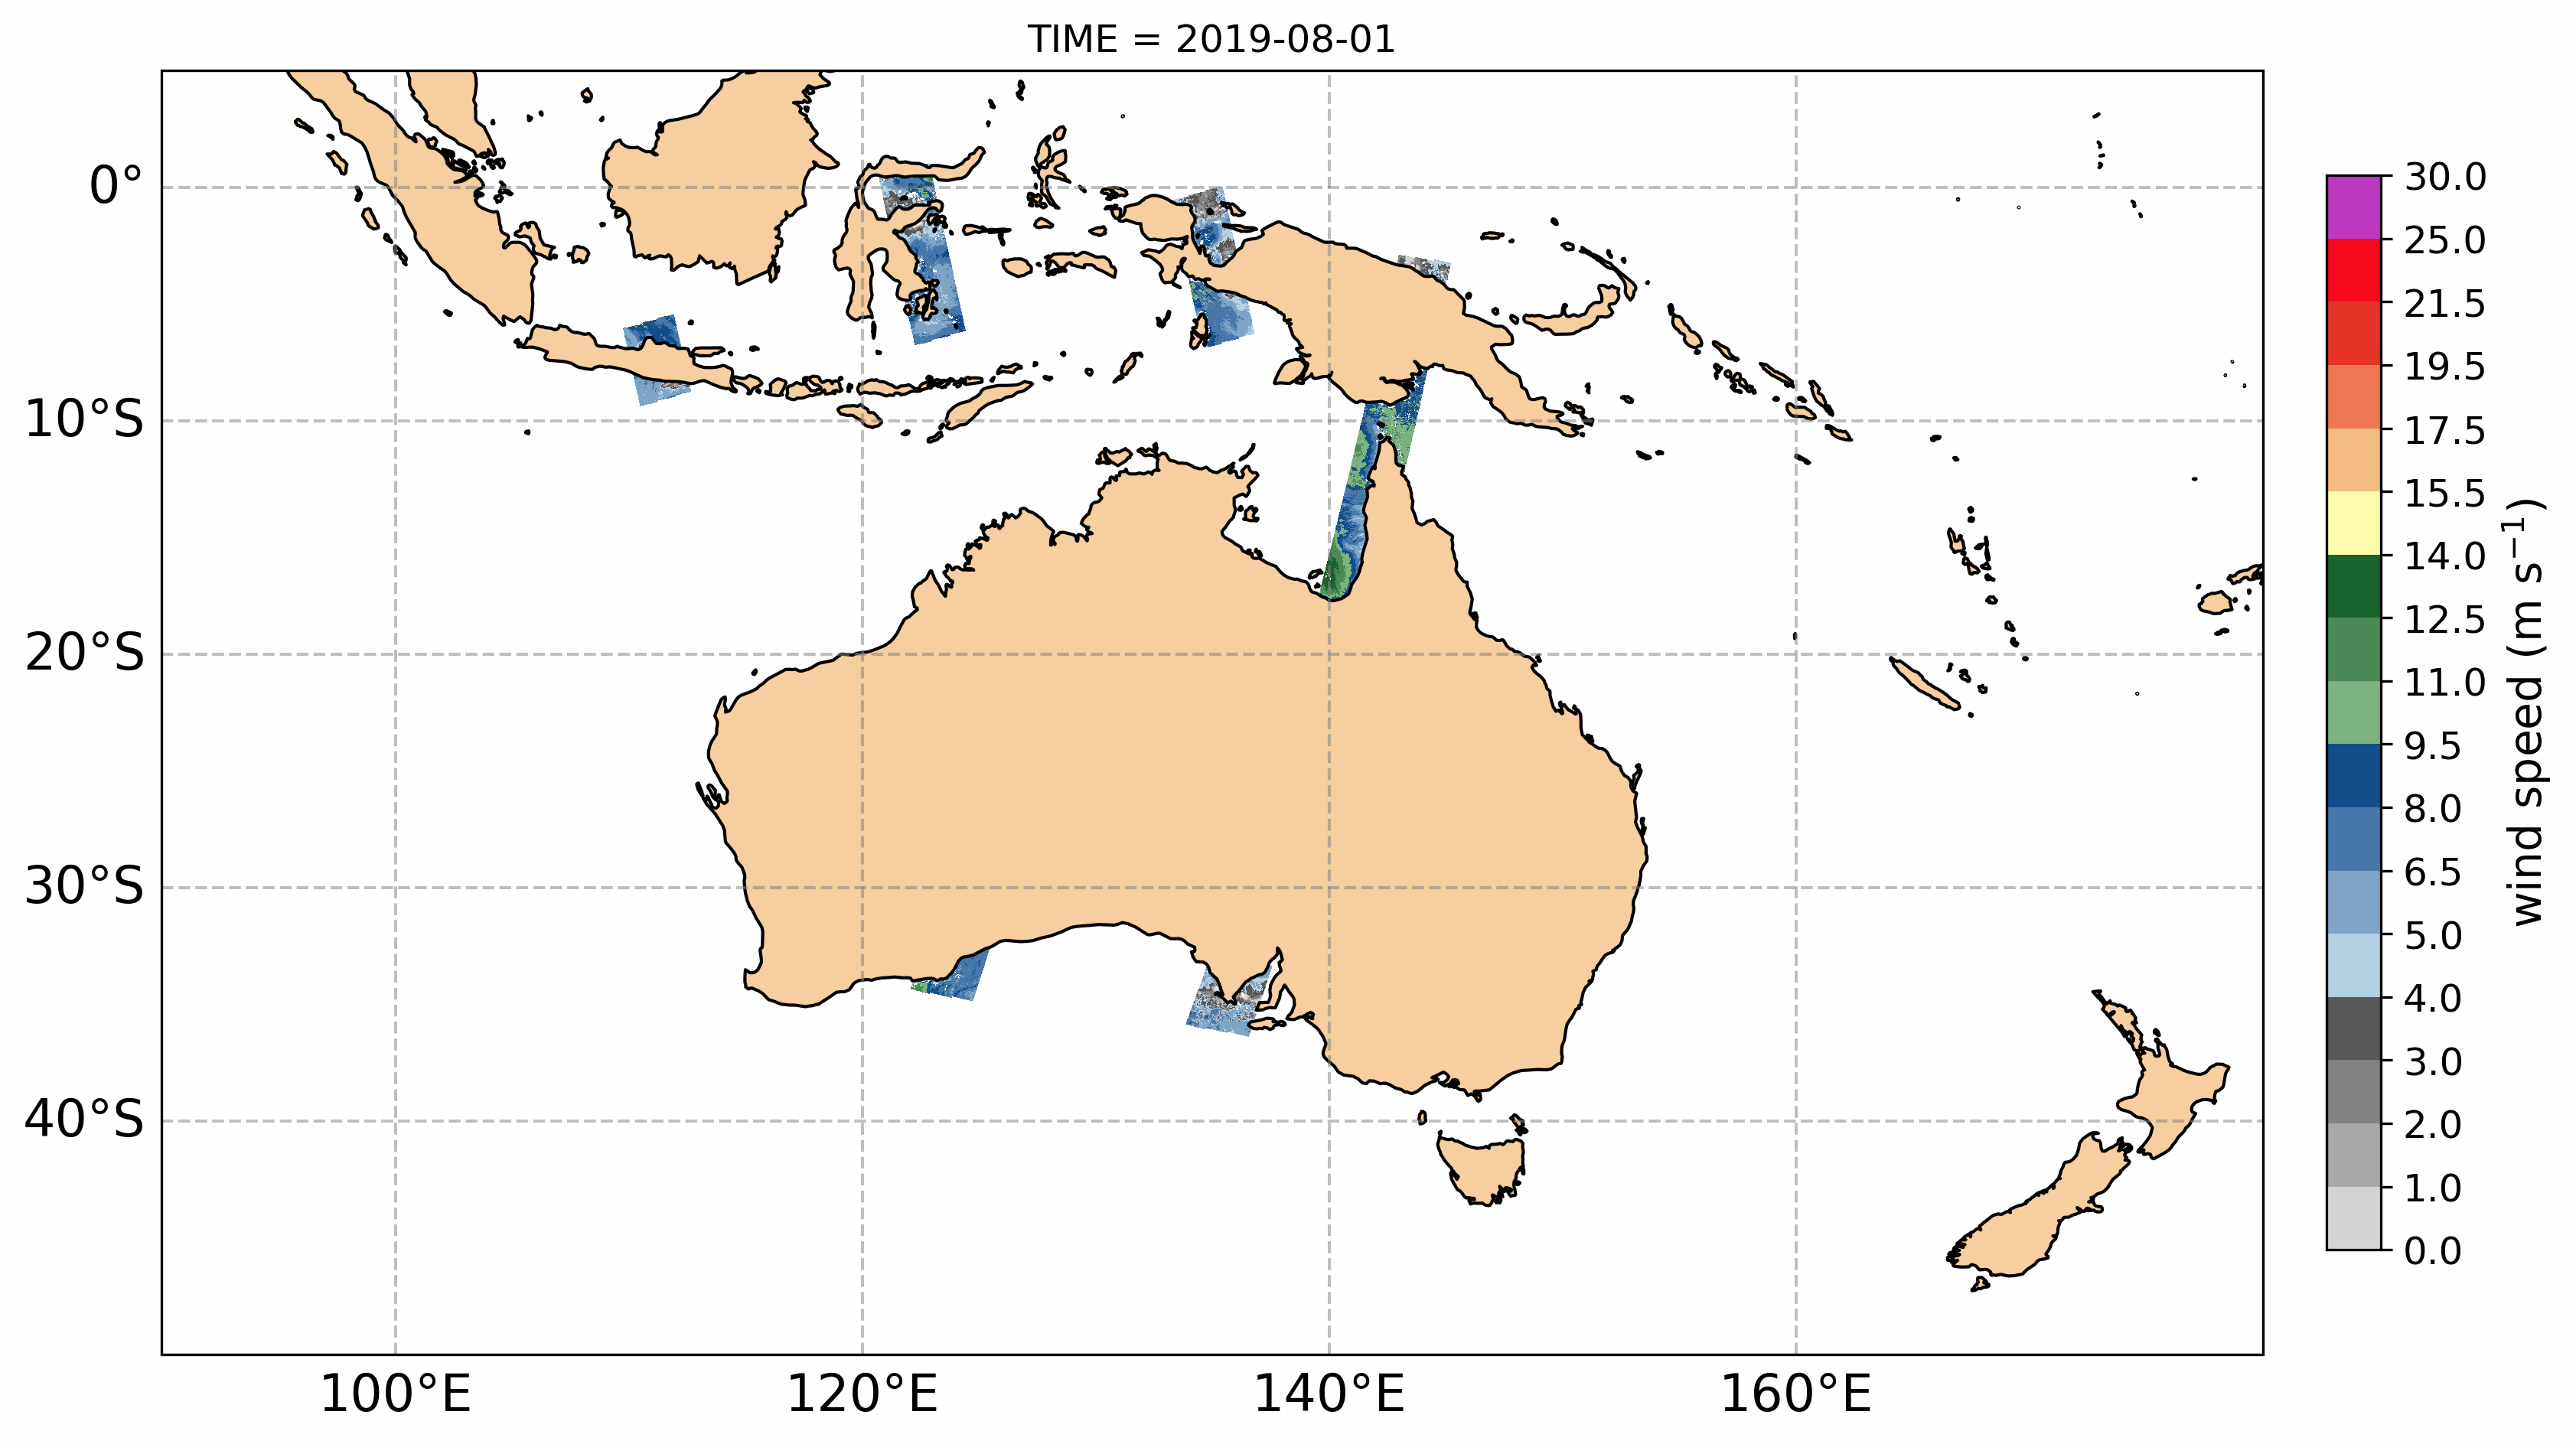

In [15]:
from IPython.display import Image, display

# Display a GIF directly
display(Image(filename="/outputfolder/plotsargriddediw/wspdcal.gif"))

## Working with multiple gridded SAR wind files - data manipulation       

* Get a list of daily file opendap urls       
* Load a subset of the data    
* Extract a slice in space or time 

In [16]:
#---Helper function for selecting a dataset subset
def subset_wspd_ds(ds):
    return ds[['TIME', 'WSPD_CAL']]

def subset_ds(ds):
    return ds[['TIME', 'WSPD_CAL', 'WDIR']]

In [17]:
from siphon.catalog import TDSCatalog
# Function to scrape NC files for a target year
def get_opendap_urls_for_year(url, year):
    cat = TDSCatalog(url)
    urls = []
    # Collect only OPeNDAP URLs for datasets containing the year
    for name, ds in cat.datasets.items():
        if str(year) in name:
            for service, link in ds.access_urls.items():
                if service.upper() == 'OPENDAP':  # Only OPeNDAP
                    urls.append(link)
    # Recursively check all subcatalogs
    for subcat_ref in cat.catalog_refs.values():
        urls.extend(get_opendap_urls_for_year(subcat_ref.href, year))
    return urls

#-----------------
# Base catalog URL
base_url = "https://thredds.aodn.org.au/thredds/catalog/IMOS/SRS/Surface-Waves/SAR_Wind/DELAYED/GRIDDED/SENTINEL-1/catalog.xml"

# Get all OPeNDAP URLs for 2019
opendap_urls_2019 = get_opendap_urls_for_year(base_url, 2019)

# Print results
print(f"Found {len(opendap_urls_2019)} OPeNDAP URLs for 2019:")
# for url in opendap_urls_2019:
#     print(url)

Found 365 OPeNDAP URLs for 2019:


</br>

### Read files for January 2019 

Lazy load a subset of the original dataset 

In [18]:
dset = xr.open_mfdataset(opendap_urls_2019[0:31], chunks='auto', 
                         concat_dim='TIME', combine ='nested', parallel=True, 
                         preprocess=subset_wspd_ds)

In [19]:
dset

<xarray.Dataset> Size: 5GB
Dimensions:    (TIME: 31, LATITUDE: 5000, LONGITUDE: 8500)
Coordinates:
  * TIME       (TIME) datetime64[ns] 248B 2019-01-01 2019-01-02 ... 2019-01-31
  * LATITUDE   (LATITUDE) float32 20kB -48.99 -48.99 -48.97 ... 0.985 0.995
  * LONGITUDE  (LONGITUDE) float32 34kB 95.0 95.01 95.03 ... 180.0 180.0 180.0
Data variables:
    WSPD_CAL   (TIME, LATITUDE, LONGITUDE) float32 5GB dask.array<chunksize=(1, 4442, 7552), meta=np.ndarray>
Attributes: (12/30)
    Conventions:                   CF-1.6,IMOS-1.4
    abstract:                      This dataset contains regularly gridded (0...
    acknowledgement:               Any users of IMOS data are required to cle...
    author:                        Khan, Salman Saeed
    author_email:                  salmansaeed.khan@csiro.au
    citation:                      The citation in a list of references is: "...
    ...                            ...
    source:                        Sentinel-1 level-2 ocean wind (owi) produc...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_start:           2019-01-01T07:46:52Z
    time_coverage_end:             2019-01-01T22:49:41Z
    cdm_data_type:                 Grid
    title:                         Daily Sentinel-1 SAR ocean surface winds r...

</br>

Slice the data for a region of interest   

In [20]:
dset = dset.sel(LATITUDE = slice(-44, -38), LONGITUDE= slice(142, 152))

</br> 
Create plots only for days where there is data for the selected region of interest

In [21]:
# Filter out time steps where WSPD_CAL is entirely NaN for the selected region
valid_times = dset['WSPD_CAL'].where(~np.isnan(dset['WSPD_CAL'])).mean(dim=("LATITUDE", "LONGITUDE"))

# Keep only times where there's at least one valid value
valid_times = valid_times.dropna(dim="TIME")

# Subset the dataset containing only days with data. This is for aesthetic purpose only so empty plots will not be displayed
dset_valid = dset.sel(TIME=valid_times['TIME'])

Text(0.5, 1.0, 'Gridded SAR wind for a region [LATITUDE: -45,-35, LONGITUDE:140,153]')

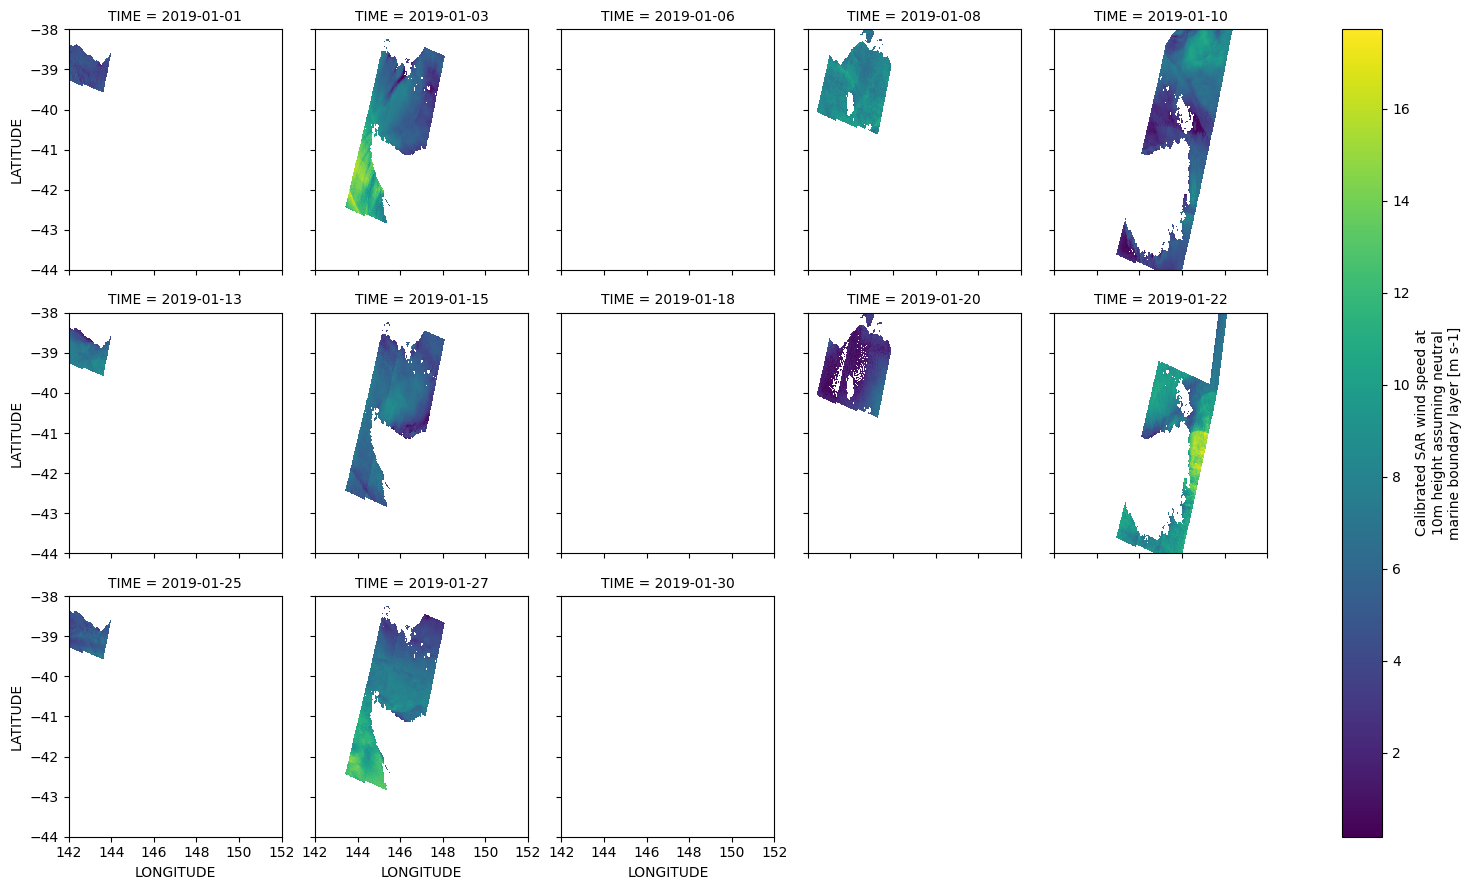

In [22]:
# Plot data selected days
dset_valid['WSPD_CAL'].plot(x="LONGITUDE", y="LATITUDE", col="TIME", col_wrap=5)
ax.set_title(f'Gridded SAR wind for a region [LATITUDE: -45,-35, LONGITUDE:140,153]')

### Plotting wind speed and direction for a spatial subset

In [23]:
dset = xr.open_mfdataset(opendap_urls_2019[0:31], chunks='auto', 
                         concat_dim='TIME', combine ='nested', 
                         parallel=True, 
                         preprocess=subset_ds)

In [24]:
dset = dset.sel(LATITUDE = slice(-44, -38), LONGITUDE= slice(142, 151))
dset

<xarray.Dataset> Size: 134MB
Dimensions:    (TIME: 31, LATITUDE: 600, LONGITUDE: 900)
Coordinates:
  * TIME       (TIME) datetime64[ns] 248B 2019-01-01 2019-01-02 ... 2019-01-31
  * LATITUDE   (LATITUDE) float32 2kB -43.99 -43.99 -43.97 ... -38.01 -38.01
  * LONGITUDE  (LONGITUDE) float32 4kB 142.0 142.0 142.0 ... 151.0 151.0 151.0
Data variables:
    WSPD_CAL   (TIME, LATITUDE, LONGITUDE) float32 67MB dask.array<chunksize=(1, 600, 900), meta=np.ndarray>
    WDIR       (TIME, LATITUDE, LONGITUDE) float32 67MB dask.array<chunksize=(1, 600, 900), meta=np.ndarray>
Attributes: (12/30)
    Conventions:                   CF-1.6,IMOS-1.4
    abstract:                      This dataset contains regularly gridded (0...
    acknowledgement:               Any users of IMOS data are required to cle...
    author:                        Khan, Salman Saeed
    author_email:                  salmansaeed.khan@csiro.au
    citation:                      The citation in a list of references is: "...
    ...                            ...
    source:                        Sentinel-1 level-2 ocean wind (owi) produc...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_start:           2019-01-01T07:46:52Z
    time_coverage_end:             2019-01-01T22:49:41Z
    cdm_data_type:                 Grid
    title:                         Daily Sentinel-1 SAR ocean surface winds r...

Text(0.5, 1.0, 'wind speed (m s$^{-1}$)')

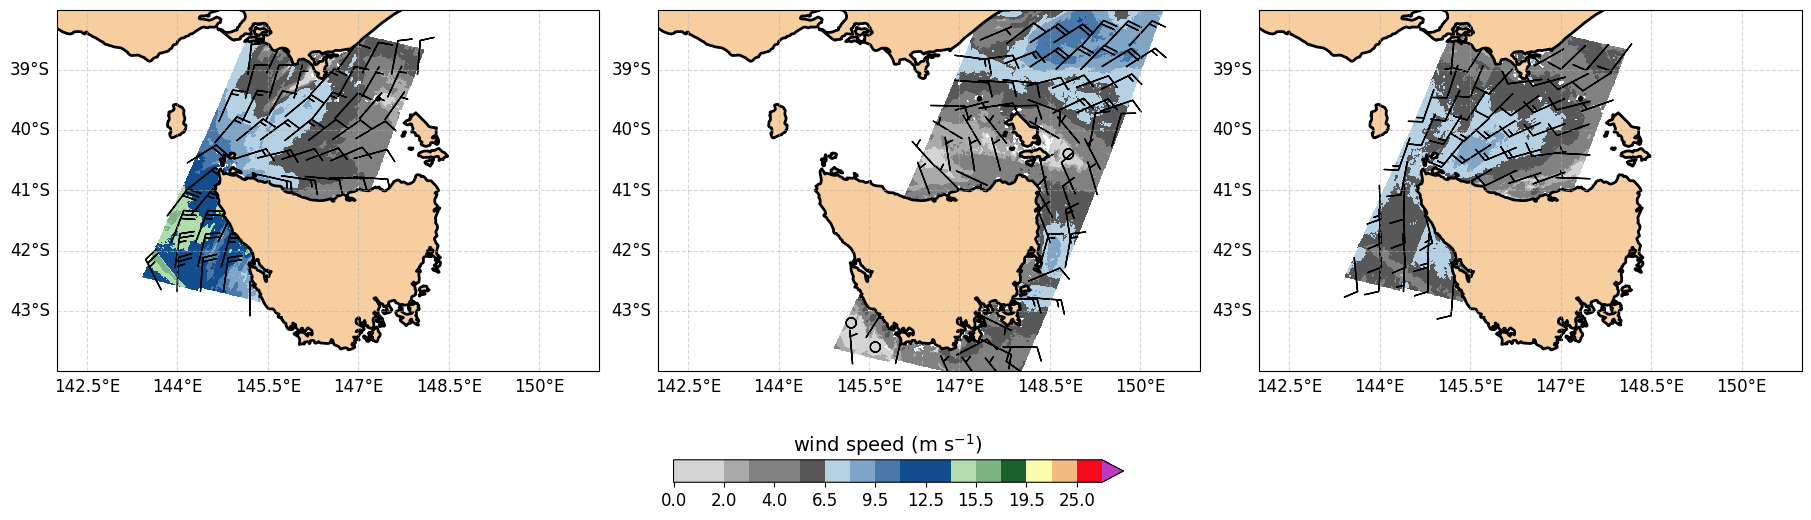

In [25]:
mps2knots = 1.944
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m')
minlon=dset['LONGITUDE'].min().data
maxlon=dset['LONGITUDE'].max().data
minlat=dset['LATITUDE'].min().data
maxlat=dset['LATITUDE'].max().data

#---Create the plot figure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6), 
                       subplot_kw={'projection': ccrs.PlateCarree()}, layout='constrained')
#---Add map features to each subplot
for a in ax:
    a.add_feature(land_10m, edgecolor='k', facecolor=land_clr, linewidth=2)
    a.add_feature(cfeature.STATES, linestyle = ':')
    a.set_extent((minlon, maxlon, minlat, maxlat))

#---Define an array of selected dates to plot
daystoplot=[2,9,14]
for i,d in enumerate(daystoplot):
    #-Plot wind speed as contour
    cs = ax[i].contourf(dset.LONGITUDE, 
                        dset.LATITUDE,
                        dset.WSPD_CAL[d,:,:],
                        levels = levels, 
                        extend = 'max',
                        cmap = cmap)    
    #-Plot wind direction  
    fact = 40
    slc = slice(None, None, fact)
    uv = to_uv(dset.WSPD_CAL[d,:,:] * mps2knots, met2math(dset.WDIR[d,:,:]))
    u = uv[0]
    v = uv[1]
    ax[i].barbs(dset.LONGITUDE.isel(LONGITUDE = slc),
             dset.LATITUDE.isel(LATITUDE = slc), 
             u.isel(LATITUDE = slc, LONGITUDE = slc),
             v.isel(LATITUDE = slc, LONGITUDE = slc),
             pivot = 'middle', transform = cart.crs.PlateCarree(), 
             color = 'k', rounding = True)
    #-Define axis features
    gl = ax[i].gridlines(draw_labels = True, linestyle = '--', alpha = 0.5)
    gl.top_labels = None
    gl.right_labels = None
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}

#---Add shared colorbar
cb_label = r"wind speed (m s$^{-1}$)"
cbar=fig.colorbar(cs, ax=ax, orientation='horizontal', fraction=.05, pad=0.075)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title(cb_label, fontsize=14)


### Extracting wind speed data for a single location

In [26]:
# Read 3months worth of data for demonstration
dset = xr.open_mfdataset(opendap_urls_2019[0:89], chunks={'TIME': 1, 'LATITUDE': 'auto', 'LONGITUDE': 'auto'}, 
                         concat_dim='TIME', combine ='nested', 
                         parallel=True, 
                         preprocess=subset_wspd_ds)

In [27]:
dset

<xarray.Dataset> Size: 15GB
Dimensions:    (TIME: 89, LATITUDE: 5000, LONGITUDE: 8500)
Coordinates:
  * TIME       (TIME) datetime64[ns] 712B 2019-01-01 2019-01-02 ... 2019-03-30
  * LATITUDE   (LATITUDE) float32 20kB -48.99 -48.99 -48.97 ... 0.985 0.995
  * LONGITUDE  (LONGITUDE) float32 34kB 95.0 95.01 95.03 ... 180.0 180.0 180.0
Data variables:
    WSPD_CAL   (TIME, LATITUDE, LONGITUDE) float32 15GB dask.array<chunksize=(1, 4442, 7552), meta=np.ndarray>
Attributes: (12/30)
    Conventions:                   CF-1.6,IMOS-1.4
    abstract:                      This dataset contains regularly gridded (0...
    acknowledgement:               Any users of IMOS data are required to cle...
    author:                        Khan, Salman Saeed
    author_email:                  salmansaeed.khan@csiro.au
    citation:                      The citation in a list of references is: "...
    ...                            ...
    source:                        Sentinel-1 level-2 ocean wind (owi) produc...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_start:           2019-01-01T07:46:52Z
    time_coverage_end:             2019-01-01T22:49:41Z
    cdm_data_type:                 Grid
    title:                         Daily Sentinel-1 SAR ocean surface winds r...

In [35]:
#---Extract data for a location for the selected year
dset_1point = dset.sel(LATITUDE=-42, LONGITUDE=144, method='nearest')

In [ ]:
dset_1point = dset_1point.compute()

Text(0.5, 1.0, 'Wind speed for location: Longitude 144.0, Longitude -42.0')

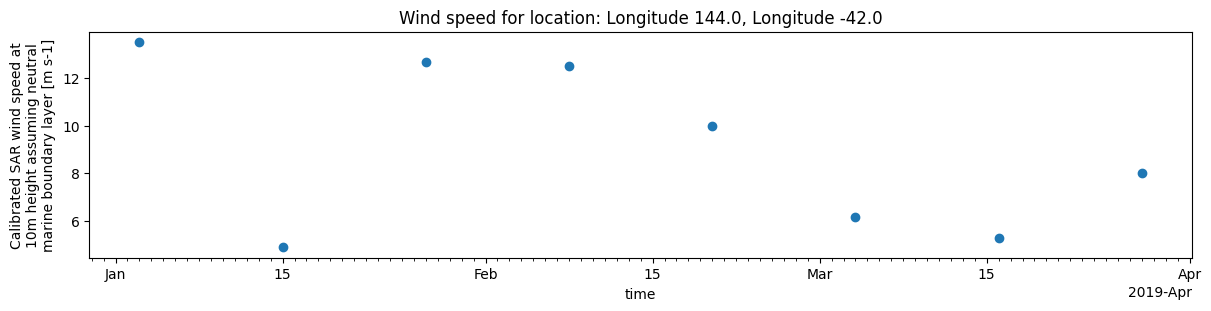

In [49]:
from matplotlib.dates import DayLocator

f, ax = plt.subplots(figsize=(12, 3), layout='constrained')
dset_1point["WSPD_CAL"].plot(ax=ax,marker='o',ls='--')
ax.xaxis.set_minor_locator(DayLocator())

lon = dset_1point.LONGITUDE.values
lat = dset_1point.LATITUDE.values
title = f"Longitude: {lon:.2f}°"
ax.set_title(f'Wind speed for location: Longitude {lon:.1f}, Longitude {lat:.1f}')